In [50]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.io import fits


from regions import Regions, RectangleSkyRegion

from astroquery.ipac.irsa import Irsa
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.visualization import AsinhStretch, ImageNormalize


In [90]:
target = "M31"
gal_center = SkyCoord.from_name(target)
wise_images = Irsa.query_sia(pos=(gal_center.ra, gal_center.dec, 1*u.arcmin), collection='wise_z0mgs')
science_image = wise_images[(wise_images['dataproduct_subtype'] == 'science') & (wise_images['energy_bandpassname'] == 'W1')][0]


with fits.open(science_image['access_url'], use_fsspec=True) as hdul:
    cutout = Cutout2D(hdul[0].section, position=gal_center, size=[2, 2] * u.deg, wcs=WCS(hdul[0].header))


In [ ]:
reffreq = 230 * u.GHz

# Overlap between adjacent OTF maps
overlap_pb_fraction = 0.5

pb_size = 1.22 * ((reffreq.to(u.m, u.spectral()) / (6 * u.m)).to(u.one).value * u.rad).to(u.arcsec)
# Round to nearest integer in arcsec
pb_size = np.ceil(pb_size)

print(f"Primary beam size: {pb_size}")

otf_overlap = overlap_pb_fraction * pb_size

print(f"Overlap between OTF maps: {otf_overlap}")


Primary beam size: 55.0 arcsec
Overlap between OTF maps: 27.5 arcsec


In [96]:
m31_full_region = Regions.read('m31_sma_full_mosaic.reg', format='ds9')[0]

m31_full_region

<RectangleSkyRegion(center=<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (10.72215791, 41.29799678)>, width=6480.2781 arcsec, height=1530.07 arcsec, angle=306.0 deg)>

In [122]:
# Number of OTF maps
n_otf = 24

# OTF map size
otf_width = 9 * u.arcmin
otf_height = 14 * u.arcmin

# Layout
Nwidth = 8
Nheight = 3

# Alter to 2 in height for the first and last row
Nheight_edges = 2

In [134]:
mosaic_regions = Regions([])

# Split full map into 4 "bricks" to be observed in same tracks.
bricks = {}
# Bricks defined by which row they cover
bricks['A'] = [0, 1]
bricks['B'] = [2, 3]
bricks['C'] = [4, 5]
bricks['D'] = [6, 7]

idx = 1

for col, ii in enumerate(range(-Nwidth // 2 + 1, Nwidth // 2 + 1)):

    if col in [0, Nwidth - 1]:
        this_Nheight = Nheight_edges
    else:
        this_Nheight = Nheight

    if Nwidth % 2 == 0:
        ii = float(ii) - 0.5

    for row, jj in enumerate(range(-this_Nheight // 2 + 1, this_Nheight // 2 + 1)):

        if this_Nheight % 2 == 0:
            jj = float(jj) - 0.5

        print(ii, jj)
        # print(col, row)

        for brick in ['A', 'B', 'C', 'D']:

            if row in bricks[brick]:
                break

        otf_map_name = f"Brick-{brick}-Row-{row+1}-Col-{col+1}"
        # print(otf_map_name)


        y_offset = jj * (otf_width - otf_overlap)
        x_offset = ii * (otf_height - otf_overlap)

        posangle = np.arctan2(x_offset, y_offset) + (m31_full_region.angle)

        separation = np.sqrt(x_offset**2 + y_offset**2)

        this_center = m31_full_region.center.directional_offset_by(posangle, separation)

        this_mosaic = RectangleSkyRegion(center=this_center,
                                         width=otf_height.to(u.arcsec),
                                         height=otf_width.to(u.arcsec),
                                         angle=m31_full_region.angle, # + 90*u.deg,
                                         meta={'name': otf_map_name})

        mosaic_regions.append(this_mosaic)

        idx += 1

# print(len(mosaic_regions))


-3.5 -0.5
-3.5 0.5
-2.5 -1
-2.5 0
-2.5 1
-1.5 -1
-1.5 0
-1.5 1
-0.5 -1
-0.5 0
-0.5 1
0.5 -1
0.5 0
0.5 1
1.5 -1
1.5 0
1.5 1
2.5 -1
2.5 0
2.5 1
3.5 -0.5
3.5 0.5


/opt/anaconda3/lib/python3.12/site-packages/regions/shapes/rectangle.py:205: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Rectangle(xy=xy, width=width, height=height,


<Figure size 640x480 with 0 Axes>

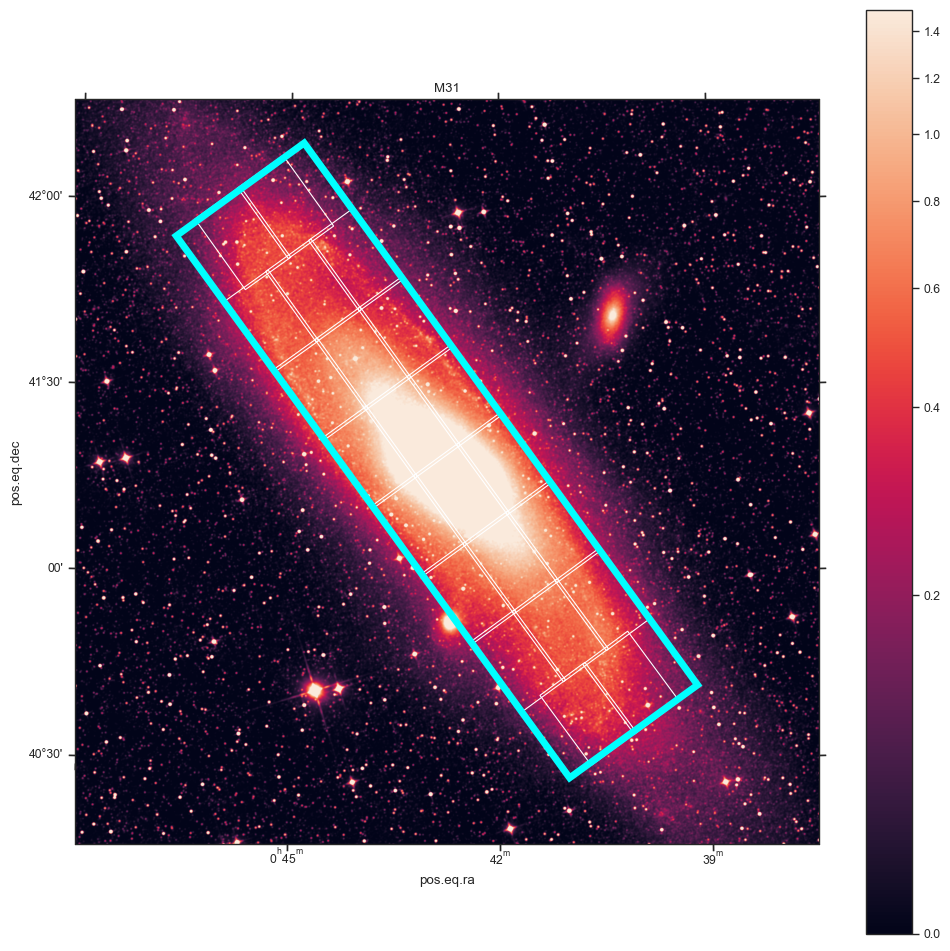

In [135]:
# Plot regions on an M31 map:
plt.clf()

fig = plt.figure(figsize=(12, 12))

stretch = AsinhStretch()
norm = ImageNormalize(stretch=stretch, vmin=0, vmax=1.5)

ax = fig.add_subplot(1, 1, 1, projection=cutout.wcs)

ax.set_title(target)
im = ax.imshow(cutout.data, origin='lower', norm=norm)
plt.colorbar(im)

# Overlay regions:
for this_region in mosaic_regions:
    # Add the region
    pixel_region = this_region.to_pixel(cutout.wcs)
    pixel_region.plot()


# # Load the whole region file that _should_ match the tiles
# gal_region = regions.Regions.read(f"{target.replace(' ', '').lower()}_region.reg")[0]
full_pixel_region = m31_full_region.to_pixel(cutout.wcs)
full_pixel_region.plot(color='cyan', lw=5.)

plt.show()


In [136]:
mosaic_regions.write('m31_sma_otf_mosaics.reg', format='ds9', overwrite=True)